In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/depression/b_depressed.csv


Имеется датасет, полученный в ходе исследования факторов, способных повлиять на депрессию людей, живущих в сельской местности. Задача модели ML --- научиться определять склонность к депрессии (0 --- не страдает, 1 --- страдает). Это типичная задача **бинарной классификации**. В лекции мы рассмотрим одну из популярных моделей для этой задачи --- логистическую регрессию.

# Логистическая регрессия

## Почему регрессия?

Прежде всего может возникнуть вопрос: почему для решения задачи классификации применяется модель под названием "регрессия"? Давайте разберёмся.

Так сложилось, что в задачах бинарной классификации мы большее значение придаём тому, чтобы научиться определять класс 1, нежели класс 0. Класс 1 представляет собой в каком-то смысле "редкое" событие: письмо со спамом, неплатёжеспособность клиента, наличие заболевания, склонность к депрессии. Будем называть его "положительным" классом, а класс 0 --- "отрицательным". Во многих ситуациях нам важнее знать **оценку вероятности** того, что объект попадёт в положительный класс (вероятность невозврата кредита, вероятность заболевания, вероятность склонности к депрессии). Тогда, задавая различные пороги для этой вероятности (в зависимости от задачи), мы будем таким образом разделять объекты.

Обозначим вероятность положительного события через $P_+$. Очевидно, что вероятность противоположного класса тогда равна $(1-P_+)$. Составим величину, называемую odds ratio ("отношение шансов"):

$$
OR = \frac{P_+}{1-P_+}.
$$

$OR$ показывает отношение вероятностей того, произойдёт наше событие или не произойдёт. При этом величины $P_+$ и $OR$ содержат, по сути, одинаковую информацию. Но если $P_+\in(0; 1)$, то $OR\in(0; +\infty)$. Если теперь рассмотреть величину логарифма отношения шансов $\log OR$, то мы придём к тому, что $\log OR\in(-\infty; +\infty)$. И вот мы получили, что можем прогнозировать **вероятность**, прогнозируя величину, лежащую от минус до плюс бесконечности! А эту величину можно предсказывать с помощью **регрессионной модели**. Voilà :)

## Сигма-функция

Пусть теперь мы прогнозируем $\log OR$ с помощью линейной регрессии: $\log OR=\mathbf{w}^T\mathbf{x}$. Как из этой величины получить $P_+$?

$$
P_+ = \frac{OR}{1+OR} = \frac{e^{\log OR}}{1+e^{\log OR}}=\frac{e^{\mathbf{w}^T\mathbf{x}}}{1+e^{\mathbf{w}^T\mathbf{x}}}=\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}}.
$$

Интересно, что мы получили здесь довольно важную функцию в машинном обучении (нет, на этот раз не логарифм :)):

$$
\sigma(z) = \frac{1}{1+e^{-z}},
$$

называемую сигма-функцией, или сигмоидой, или **логистической функцией**. Она ведёт себя так:
![](https://www.researchgate.net/profile/John_Davis82/publication/234049070/figure/fig6/AS:300093912698893@1448559372458/Logistic-sigmoid-function-Maps-real-numbers-to-the-interval-between-0-and-1.png)

Итак, $P_+=\sigma(\mathbf{w}^T\mathbf{x})$. Это важный результат.

Тем самым, с помощью логистической регрессии мы будем прогнозировать **вероятность принадлежности объекта к классу 1**.

## LogLoss, или логистическая функция потерь

Следующий важный момент: **как считать ошибку модели в случае бинарной классификации**? Иными словами, как выбрать функцию потерь и составить функционал качества?

Вновь вспомним принцип максимального правдоподобия. Только что мы получили, что

$$
P_+ = P(y=1 | \mathbf{x}_i, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x}).
$$

Но тогда

$$
P_- = P(y=-1 | \mathbf{x}_i, \mathbf{w}) = 1 - P_+ = 1 - \sigma(\mathbf{w}^T\mathbf{x}_i).
$$

Здесь мы обозначили класс "0" как "-1" для удобства выкладок. Далее можно заметить (проверьте!), что $1 - \sigma(\mathbf{w}^T\mathbf{x}_i)=\sigma(-\mathbf{w}^T\mathbf{x}_i)$: первое из поразительных свойств сигмоиды --- то ли ещё будет! Учитывая последнее, можно записать **общую формулу** для вероятности:

$$
P(y=y_i | \mathbf{x}_i, \mathbf{w}) = \sigma(y_i\mathbf{w}^T\mathbf{x}_i).
$$

Тогда вероятность всей выборки (взятой независимо и из одного распределения) запишется как произведение вероятностей:

$$
P(\mathbf{y}|\mathbf{X}, \mathbf{w}) = \prod_{i=1}^{l} P(y=y_i | \mathbf{x}_i, \mathbf{w}).
$$

Это **функция правдоподобия выборки**. Её нужно максимизировать. Как обычно, вместо максимизации произведения множества слагаемых нам бы хотелось максимизировать сумму. Поэтому возьмём логарифм правдоподобия:

$$
\begin{multline*}
\log P(\mathbf{y}|\mathbf{X}, \mathbf{w}) = \log \prod_{i=1}^{l} P(y=y_i | \mathbf{x}_i, \mathbf{w}) = 
\sum_{i=1}^{l} \log P(y=y_i | \mathbf{x}_i, \mathbf{w}) = \\
=\sum_{i=1}^{l} \log \sigma(y_i\mathbf{w}^T\mathbf{x}_i) = \sum_{i=1}^{l} \log \frac{1}{1+e^{-y_i\mathbf{w}^T\mathbf{x}_i}}=-\sum_{i=1}^{l}\log \left(1+e^{-y_i\mathbf{w}^T\mathbf{x}_i}\right) \to \max\limits_\mathbf{w},
\end{multline*}
$$

то есть максимизация прадоподобия эквивалентна минимизации функционала

$$
Q(\mathbf{w}) = \sum_{i=1}^{l}\log \left(1+e^{-y_i\mathbf{w}^T\mathbf{x}_i}\right) \to \min\limits_\mathbf{w}.
$$

Последний функционал под знаком суммы содежит **логистическую функцию потерь**, или лог-лосс: $L_{log}(z)=\log(1+e^{-z})$. Её график выглядит следующим образом:
![](https://www.researchgate.net/profile/Thomas_Hofmann10/publication/2877976/figure/fig1/AS:650449568923660@1532090670890/Loss-values-of-0-1-exp-and-log-loss-functions-in-a-binary-classification-problem.png)

и мажорирует обычную пороговую функцию потерь:
$$
L(y, \widehat{y}) = \begin{cases}0, & \text{if } y=\widehat{y}, \\ 1, & \text{if } y\neq\widehat{y}. \end{cases}
$$

Итак, мы только что показали, что, с точки зрения статистики и метода максимального правдоподобия, **оптимальным выбором функции потерь** для логистической регрессии является **лог-лосс**, или **логистическая функция потерь**. Минимизируя лог-лосс, мы тем самым уменьшаем число ошибок классификации.

## Регуляризация логистической регрессии

В моделях логистической регрессии, как и в линейной регрессии, используют разные типы **регуляризации** ($L_1$, $L_2$, Elastic Net) для уменьшения переобучения модели. Функционал качества в случае $L_2$-регуляризации выглядит так:

$$
Q_{reg}(\mathbf{w}) = C\cdot \sum_{i=1}^{l}\log \left(1+e^{-y_i\mathbf{w}^T\mathbf{x}_i}\right)+\|\mathbf{w}\|^2 \to \min\limits_\mathbf{w}.
$$

Здесь гиперпараметр $C>0$ играет роль **обратной силы регуляризации**. Чем больше $C$, тем меньше "штраф" за увеличение весов модели. И наоборот, чем меньше $C$, тем эффект регуляризации больше.

## Почему логистическая регрессия --- это линейный классификатор?

Мы ещё не обсудили вопрос, почему же рассмотренная нами модель относится к **линейным моделям**. Для этого рассмотрим игрушечный пример с точками на плоскости.

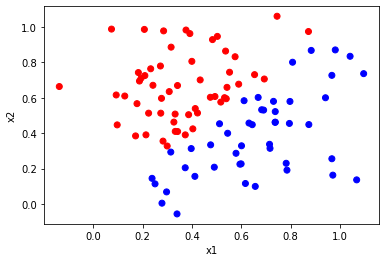

In [2]:
np.random.seed(0)
import matplotlib.pyplot as plt
X = np.random.normal(loc=0.5, scale=0.25, size=(100, 2))
y = (X[:, 1] > X[:, 0]).astype('int') # разделяющая граница: y=x (биссектриса первой четверти)
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in y])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

w = log_reg.coef_
bb = log_reg.intercept_

print(w, bb)

[[-3.29153106  3.02599673]] [0.23181665]


Построим разделяющую границу между классами, которую "выучила" наша модель. Для этого запишем уравнение
$$
w_1\cdot x_1 + w_2\cdot x_2 + b = 0
$$
и выразим из него $x_2$ для более привычного построения графика:
$$
x_2 = -\frac{w_1}{w_2}x_1-\frac{b}{w_2}.
$$

In [4]:
w1 = w[0][0]
w2 = w[0][1]
b = bb[0]

print('w1 = '+str(w1), '\nw2 = '+str(w2), '\nb = '+str(b))

w1 = -3.2915310634294572 
w2 = 3.0259967314775613 
b = 0.2318166472532856


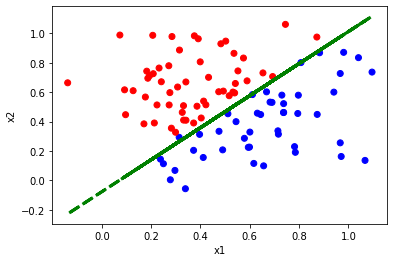

In [5]:
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in y])
plt.plot(X[:, 0], -w1/w2*X[:, 0]-b/w2, color='green', linewidth=3, linestyle="dashed")

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Итак, модель логистической регрессии почти идеально восстановила нашу разделяющую границу. А что будет, если разделяющая граница нелинейна?

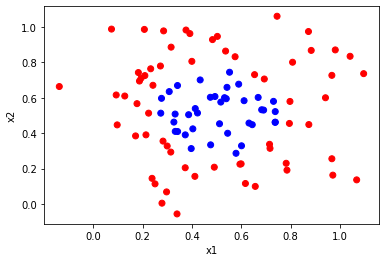

In [6]:
yy = ((X[:, 0]-0.5)**2 + (X[:, 1]-0.5)**2 > 0.25**2).astype('int')
plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in yy])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Теперь посмотрим, что выучит наша модель.

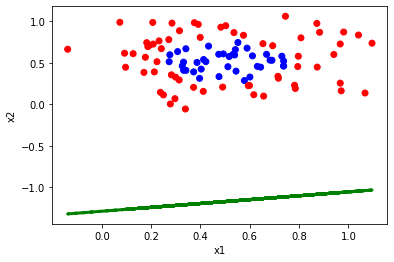

In [7]:
log_reg = LogisticRegression()
log_reg.fit(X, yy)

w1 = log_reg.coef_[0][0]
w2 = log_reg.coef_[0][1]
b = log_reg.intercept_[0]

plt.scatter(X[:, 0], X[:, 1], color=['red' if c==1 else 'blue' for c in yy])
plt.plot(X[:, 0], -w1/w2*X[:, 0]-b/w2, color='green', linewidth=3, linestyle="dashed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Как видим, несмотря на изменения в исходных данных, модель по-прежнему "учит" только линейную границу между классами, причём в данном случае далеко от идеала.

Тем не менее, в многомерных пространствах картинка получается лучше, и даже линейный классификатор способен дать хороший результат. Кроме того, мы можем использовать приём, который называется **"создание полиномиальных признаков"**. Это означает, что, помимо $x_1, x_2, \ldots, x_n$, модель также рассматривает их попарные произведения степени не выше $k$ (в случае $k=2$ это будут $x_1^2$, $x_1x_2$, $x_2^2$) в качестве признаков. Этот приём описан в [статье](https://habr.com/ru/company/ods/blog/323890/) OpenDataScience-сообщества (раздел 4). 

# Логистическая регрессия в действии

## Загрузка и препроцессинг

In [8]:
df = pd.read_csv('/kaggle/input/depression/b_depressed.csv')
df.head()

,Survey_id,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
0,926,91,1,28,1,4,10,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1,747,57,1,23,1,3,8,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
2,1190,115,1,22,1,3,9,5,28912201,22861940,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
3,1065,97,1,27,1,2,10,4,52667108,19698904,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
4,806,42,0,59,0,4,10,6,82606287,17352654,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 23 columns):
Survey_id                1429 non-null int64
Ville_id                 1429 non-null int64
sex                      1429 non-null int64
Age                      1429 non-null int64
Married                  1429 non-null int64
Number_children          1429 non-null int64
education_level          1429 non-null int64
total_members            1429 non-null int64
gained_asset             1429 non-null int64
durable_asset            1429 non-null int64
save_asset               1429 non-null int64
living_expenses          1429 non-null int64
other_expenses           1429 non-null int64
incoming_salary          1429 non-null int64
incoming_own_farm        1429 non-null int64
incoming_business        1429 non-null int64
incoming_no_business     1429 non-null int64
incoming_agricultural    1429 non-null int64
farm_expenses            1429 non-null int64
labor_primary            1429 non-null

In [10]:
df.nunique()

Survey_id                1429
Ville_id                  255
sex                         2
Age                        71
Married                     2
Number_children            12
education_level            18
total_members              12
gained_asset              441
durable_asset             590
save_asset                268
living_expenses           411
other_expenses            615
incoming_salary             2
incoming_own_farm           2
incoming_business           2
incoming_no_business        2
incoming_agricultural     330
farm_expenses             694
labor_primary               2
lasting_investment        982
no_lasting_investmen      939
depressed                   2
dtype: int64

Все столбцы числовые, однако данные всё ещё не готовы к построению модели. Нам необходимо:
* убрать пропуски (в столбце **no_lasting_investmen**);
* убрать лишний признак **Survey_id** (номер опроса);
* перевести категориальные признаки в бинарные (get_dummies);
* стандартизировать признаки с неудобным масштабом.

In [11]:
# Удалим пропуски
df_1 = df.dropna()

# Дропнем ненужные столбцы
df_2 = df_1.drop(['Survey_id', 'depressed'], axis=1)

# Переведём признаки "Номер виллы" и "Уровень образования" в бинарные 
# * мы не уверены на 100 %, что уровень образования ранговый, поэтому считаем его категориальным
df_3 = pd.get_dummies(df_2, columns=['Ville_id', 'education_level'])

# Масштабирование
col_names = df.columns.values # это имена всех столбцов
large_numbers = [col for col in col_names if df[col].mean() > 10000] # имена тех, у кого среднее > 10000
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_st = scaler.fit_transform(df_3[large_numbers])

# Переприсвоим старым колонкам новые
df_3[large_numbers] = X_st

df_3.head()

,sex,Age,Married,Number_children,total_members,gained_asset,durable_asset,save_asset,living_expenses,other_expenses,...,education_level_9,education_level_10,education_level_11,education_level_12,education_level_13,education_level_14,education_level_16,education_level_17,education_level_18,education_level_19
0,1,28,1,4,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,0,1,0,0,0,0,0,0,0,0
1,1,23,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,0,0,0,0,0,0,0,0,0,0
2,1,22,1,3,5,-0.233851,-0.233363,-0.227442,-0.275851,-0.251273,...,1,0,0,0,0,0,0,0,0,0
3,1,27,1,2,4,0.949678,-0.408733,1.248573,-1.527659,0.482377,...,0,1,0,0,0,0,0,0,0,0
4,0,59,0,4,6,2.441322,-0.538818,-0.227442,2.303754,1.893300,...,0,1,0,0,0,0,0,0,0,0


## Построение модели и валидация

In [12]:
X = df_3
y = df_1['depressed']

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

In [13]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))

0.8470254957507082


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Метрики на основе confusion matrix

Разберёмся, так ли хороша наша модель, как кажется (accuracy=84.7 %). Для начала посмотрим на соотношение классов в задаче.

In [14]:
y.value_counts(normalize=True)

0    0.833215
1    0.166785
Name: depressed, dtype: float64

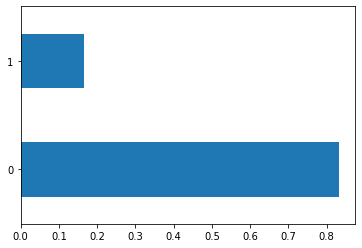

In [15]:
y.value_counts(normalize=True).plot(kind='barh')
plt.show()

Мы видим, что объектов класса 0 в выборке значительно больше (83.3 %), чем объектов класса 1. Если бы мы решили построить константный классификатор, который предсказывает 0 ВСЕГДА, то accuracy такого классификатора была бы примерно 83.3 %. Из этого можно сделать вывод, что accuracy --- далеко не лучший выбор метрики качества для случая несбалансированных классов.

Какие же есть альтернативы? Прежде всего, это матрица ошибок (confusion_matrix). В ней по строкам расположены истинные значения классов, а по столбцам --- предсказанные моделью. Их обычно обзначают так:
$$
\text{Confusion_Matrix}=
\begin{array}{c|cc} 
& \text{0_pred} & \text{1_pred} \\ \hline
\text{0_true} & TN & FP \\ 
\text{1_true} & FN & TP\end{array}
$$

Здесь:
* $TN$ --- True Negative (правильный отрицательный) --- количество объектов класса 0, которые модель опознала верно;
* $TP$ --- True Positive (правильный положительный) --- количество объектов класса 1, которые модель опознала верно;
* $FP$ --- False Positive (ложный положительный) --- количество объектов класса 0, которые модель ошибочно отнесла к классу 1;
* $FN$ --- False Negative (ложный отрицательный) --- количество объектов класса 1, которые модель ошибочно отнесла к классу 0.

В идеальном случае данная матрица содержит нули вне главной диагонали. На практике же, в зависимости от задачи, мы бы хотели **минимизировать** значения $FN$ либо $FP$. К примеру, в задаче обнаружения спама нам бы не хотелось, чтобы модель помечала как спам нормальные письма, т. е. хотим как можно меньше **ложных срабатываний** (False Positive). В задаче же медицинской диагностики куда важнее не пропустить больных (т. е. нужно минимизировать **пропуски класса 1**, False Negative).

Построим такую матрицу в нашей задаче обнаружения склонности к депрессии.

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(y_valid, y_pred))

[[297   4]
 [ 50   2]]


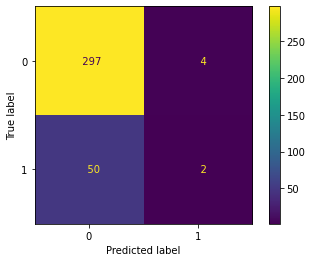

In [17]:
plot_confusion_matrix(log_reg, X_valid, y_valid, values_format='5g')
plt.show()

Итак, наша модель определяет 4 человек как склонных к депрессии (в то время как они "здоровы"), а также 50 человек помечает "здоровыми", в то время как они склонны к депрессии. Последнее обстоятельство явно не очень хорошо. Ведь всего у нас было 52 случая склонности к депрессии, из которых модель сумела найти только два!

### Точность, полнота и F-мера

На основе матрицы ошибок можно построить следующие три метрики, каждая из которых лучше отображает результаты классификации для несбалансированных классов. Это **точность** (precision), **полнота** (recall) и **F-мера** (f1_score).

$$
\text{Confusion_Matrix}=
\begin{array}{c|cc} 
& \text{0_pred} & \text{1_pred} \\ \hline
\text{0_true} & TN & FP \\ 
\text{1_true} & FN & TP\end{array}
$$

* $\text{Precision}=\dfrac{TP}{TP+FP}$: показывает, насколько можно "доверять" модели, если она показала класс 1;
* $\text{Recall}=\dfrac{TP}{TP+FN}$: показывает, как хорошо модель умеет находить класс 1;
* $F_1=\dfrac{2\cdot \text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}$: гармоническое среднее между точностью и полнотой.

Таким образом, 
* если мы хотим минимизировать $FP$, то лучше в качестве метрики брать precision;
* если мы хотим минимизировать $FN$, то лучше в качестве метрики брать recall;
* если мы сомневаемся или хотим минимизировать оба значения, лучше подойдёт f1_score.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision:', precision_score(y_valid, y_pred))
print('Recall:', recall_score(y_valid, y_pred))
print('F1 score:', f1_score(y_valid, y_pred))

Precision: 0.3333333333333333
Recall: 0.038461538461538464
F1 score: 0.06896551724137931


## Настройка гиперпараметров логистической регрессии по f1_score

Попробуем настроить параметр C (силу регуляризации) для каждого типа регуляризации.

### Регуляризация L2 (по умолчанию)

In [19]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(solver='liblinear')

C_values = {'C': np.logspace(-3, 3, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [20]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1000.0}
0.20190932733305617


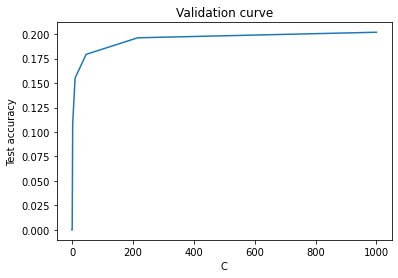

In [21]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

### Регуляризация L1

In [22]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1')

C_values = {'C': np.logspace(-3, 3, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [23]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 215.44346900318823}
0.20190932733305617


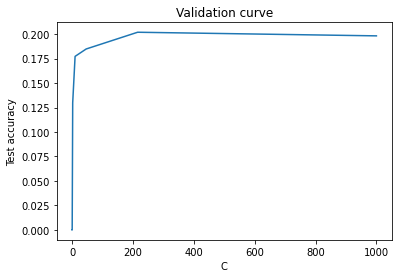

In [24]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [25]:
y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[273  28]
 [ 45   7]]
F1 score valid: 0.16091954022988506


Стала ли наша модель лучше? Однозначно сказать трудно :)

Однако уже понятно, что модель недообучена (слабый результат на train + слабый результат на valid). Возможно, в неё стоит добавить полиномиальные фичи. Но тогда возникнет проблема: число признаков больше числа объектов. Другая возможная причина: у нас просто мало данных (всего около 1400 объектов).

# Попытки улучшить модель

In [26]:
# kNN (не помог)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[288  13]
 [ 49   3]]
F1 score valid: 0.08823529411764705


In [27]:
knn_params = {'n_neighbors': np.arange(1, 50, 2)}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train, y_train)

y_pred = knn_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[257  44]
 [ 45   7]]
F1 score valid: 0.13592233009708737


In [28]:
# Random Forest (не помог)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[299   2]
 [ 51   1]]
F1 score valid: 0.03636363636363637


In [29]:
# Искусственное добавление объектов класса 1

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

Using TensorFlow backend.


In [30]:
# Проверим баланс
y_ros.value_counts()

1    873
0    873
Name: depressed, dtype: int64

In [31]:
# Логистическая регрессия с добавлением класса 1
logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(X_ros, y_ros)
y_pred = logreg_ros.predict(X_valid)

print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[213  88]
 [ 37  15]]
F1 score valid: 0.19354838709677416


In [32]:
# Подбор гиперпараметров
logreg_params = {'C': np.logspace(-3, 3, 10), 'penalty': ['l2', 'l1']}
logreg_grid = GridSearchCV(logreg_ros, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_ros, y_ros)

y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[201 100]
 [ 36  16]]
F1 score valid: 0.1904761904761905
